In [1]:
%load_ext watermark

In [2]:
%watermark -a Schmelling,Nicolas -u -d -v -p matplotlib,numpy,pandas

Schmelling,Nicolas 
last updated: 2017-01-03 

CPython 3.5.2
IPython 4.1.1

matplotlib 1.5.1
numpy 1.10.4
pandas 0.18.0


---
Any comments and suggestions or questions?     
Please feel free to contact me via [twitter](https://twitter.com/DerSchmelling) or [email](mailto:Nicolas.Schmelling@hhu.de).

---

## Distribution of circadian clock proteins ##

In the previous [IPython notebook](1_KaiABC_BLAST_Data_Collection_and_Perprocessing.ipynb) we collected the data and preformed some preprocessing steps. In this notebook we continued to preprocess the data such that it fits the desired analyses. Afterwards we visualized the data in three heatmaps containing the percent identity of the reciprocal BLAST and the count of protein homologs in cyanobacteria.

### Preprocessing ###

1. Grouping the genera in the four groups according to their taxonomy. Groups are Cyanobacteria, Proteobacteria, Archaea, and Other Bacteria. Assign a numeric identifier to each group for coloring.
2. Calculating the identity mean for each protein and genus. A counter of each genus to record the number of individual organisms per genus will be created.
3. Merging the the dataframes for each protein into a single dataframe containing information about protein identity for each protein and genus.
4. Creating another dataframe containing the homologous copy number for each protein in cyanobacteria.

In [3]:
import re

import matplotlib as mlp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd

%matplotlib inline

In [4]:
pd.set_option('mode.chained_assignment',None)

In [5]:
'''
The function will group the genera in to four groups according to
their taxonomy.Groups are Cyanobacteria, Proteobacteria, 
Archaea, and Other Bacteria. The function will also assign a numeric 
identifier to each group for later coloring.
'''
def categories_taxonomy(df):
    
    count = 0
    
    df['colormap'] = np.zeros(len(df.index))
    
    for i in list(df.taxonomy):
        if 'cyanobacteria' in str(i).lower():
            df.taxonomy[count] = 1
            df['colormap'][count] = 3
            count += 1
        elif 'proteobacteria' in str(i).lower():
            df.taxonomy[count] = 3
            df['colormap'][count] = 2
            count += 1
        elif 'archaea' in str(i).lower():
            df.taxonomy[count] = 4
            df['colormap'][count] = 1
            count += 1
        else:
            df.taxonomy[count] = 5
            df['colormap'][count] = 9
            count += 1
    
    return df

'''
The function will first call the function categories_taxonomy() and 
selects only cyanobacteria. Next a counter to record the number protein 
homologs of individual organisms will be created.
'''
def create_count_df(path, prot_name, df_merge, how='left'):
    
    df = pd.read_csv(path)
    df = categories_taxonomy(df)
    df = df[df.taxonomy == 1]
    
    leng = prot_name + '_length'
    coun = prot_name + '_count'
    
    df = df[['name',leng]]
    df = df[df[leng] > 0].drop_duplicates()
    df[coun] = df.groupby(['name']).transform('count')
    df = df[['name',coun]].drop_duplicates()
    
    df_new = pd.merge(df_merge, df, how=how)
    
    return df_new

'''
The function will first call the function create_count_df() and further 
calculate the identity mean for each protein and genus. It will also
remove all special characters, change the genus name of all organisms
labeled as 'Candidatus', and create a counter for each genus 
to record the number of individual organisms per genus. 
'''
def prepare_df(df, prot):
    
    df = categories_taxonomy(df)
    df = df[['name','genus','taxonomy','colormap','identity','genome_id']]
    
    count = 0
    for genus in df['genus']:
        df['genus'][count] = re.sub('[^a-zA-Z0-9 \n\.]', '', genus)
        if genus == 'Candidatus':
            df['genus'][count] = df['name'][count].split(' ',2)[1]
        count += 1
        
    df = df.groupby(['name','genus','taxonomy','colormap','genome_id']).mean()
    df = df.reset_index()
    df['%s_count'%prot] = df.drop_duplicates(subset=['name'])\
                                            [['name','genus']]\
                                            .groupby(['genus'])\
                                            .transform('count')
    df = df[['name','genus','taxonomy','colormap','identity','%s_count'%prot]]
    df.columns = ['name', 'genus', 'taxonomy','colormap',\
                  '%s_identity'%prot,'%s_count'%prot]
    df = df.groupby(['name','genus','taxonomy']).mean()
    df = df.reset_index()
    
    return df

'''
Read the CSV of a given protein and run the prepare_df() function.
'''
def process_df(prot):
    
    df = pd.read_csv('../data/%s.csv'%prot)
    df = prepare_df(df, prot)
    
    return df

'''
The function will read a given CSV file, runs the categories_taxonomy function
and selects only cyanobacteria. Next a counter to record the number protein 
homologs of individual organisms will be created. Last the resulting
two column dataframe will be merged with a given existing dataframe.
'''
def create_count_df(path, prot_name, df_merge, how='left'):
    
    df = pd.read_csv(path)
    df = categories_taxonomy(df)
    df = df[df.taxonomy == 1]
    
    leng = prot_name + '_length'
    coun = prot_name + '_count'
    
    df = df[['name','length']]
    df.columns = ['name',leng]
    df = df[df[leng] > 0].drop_duplicates()
    df[coun] = df.groupby(['name']).transform('count')
    df = df[['name',coun]].drop_duplicates()
    
    df_new = pd.merge(df_merge, df, how=how)
    
    return df_new

### Create the sequence identity dataframes ###

In [6]:
# Run the process_df() function for all Synechococcus proteins
for protein in ['kaiA', 'kaiB', 'kaiC', 'cpmA', 'ircA', 'pex', 'cdpA',
                'ldpA', 'labA', 'lalA', 'cikA', 'sasA', 'nhtA', 'prkE',
                'crm', 'rpaA', 'rpaB']:
    globals()[protein] = process_df(protein)

In [7]:
# Create a list of genera that are removed later from the dataset,
# which were falsely recorded.
kaiC_orgs = list(set(kaiC.genus))

not_found = ['Oscillatoriales', 'Opitutaceae', 'halophilic',
             'Candidatus', 'Aquifex', 'Filomicrobium', 'Ziziphus']

orgs = list(set(kaiC_orgs) - set(not_found))

In [8]:
# Merge the dataframes of each protein into one dataframe.
# First merge the dataframes containing information about KaiA, KaiB and KaiC.
# Remove all genera that are not in the organism list created before.
kaiC = kaiC[kaiC.genus.isin(orgs)]
df_Sy7942 = pd.merge(kaiC,kaiA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, kaiB, how='left')

# Merge the df_Sy7942 dataframe with the rest of the protein dataframes.
df_Sy7942 = pd.merge(df_Sy7942, cpmA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, ircA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, pex, how='left')
df_Sy7942 = pd.merge(df_Sy7942, cdpA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, ldpA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, labA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, lalA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, cikA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, sasA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, prkE, how='left')
df_Sy7942 = pd.merge(df_Sy7942, nhtA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, crm, how='left')
df_Sy7942 = pd.merge(df_Sy7942, rpaA, how='left')
df_Sy7942 = pd.merge(df_Sy7942, rpaB, how='left')

df_Sy7942 = df_Sy7942.groupby(['genus','taxonomy']).mean()
df_Sy7942 = df_Sy7942.reset_index()

df_Sy7942['rank'] = np.zeros(len(df_Sy7942))

# Change the genus of a special cyanobacterium
id = df_Sy7942[df_Sy7942.genus == 'cyanobacterium'].taxonomy.index[0]
df_Sy7942.genus[id] = 'Endosymbiont'

# Reduce the number of columns down to the one needed for the heatmap.
df_Sy7942 = df_Sy7942[['genus', 'taxonomy', 'colormap', 'rank',
                       'kaiA_identity', 'kaiB_identity', 'kaiC_identity',
                       'pex_identity', 'ldpA_identity', 'prkE_identity',
                       'nhtA_identity', 'ircA_identity', 'cdpA_identity',
                       'cikA_identity', 'sasA_identity', 'labA_identity',
                       'lalA_identity', 'crm_identity', 'rpaA_identity',
                       'rpaB_identity', 'cpmA_identity', 'kaiC_count']]

In [9]:
# Read the input data for each single protein and run the two function above.
for protein in ['kaiB1', 'kaiB2', 'kaiB3', 'kaiC1', 'kaiC2', 'kaiC3']:
    globals()[protein] = process_df(protein)

In [10]:
df_Sy6803 = pd.merge(kaiB1,kaiB2, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiB3, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiC1, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiC2, how='outer')
df_Sy6803 = pd.merge(df_Sy6803, kaiC3, how='outer')
df_Sy6803 = df_Sy6803.drop_duplicates()
df_Sy6803 = df_Sy6803[df_Sy6803.genus.isin(orgs)]

df_Sy6803 = df_Sy6803.groupby(['genus','taxonomy']).mean()
df_Sy6803 = df_Sy6803.reset_index()

df_Sy6803['rank'] = np.zeros(len(df_Sy6803))

# Change the genus of a special cyanobacterium
id = df_Sy6803[df_Sy6803.genus == 'cyanobacterium'].taxonomy.index[0]
df_Sy6803.genus[id] = 'Endosymbiont'

# Reduce the number of columns down to the one needed for the heatmap.
df_Sy6803 = df_Sy6803[['genus', 'taxonomy', 'colormap', 'rank',
                       'kaiB1_identity', 'kaiB2_identity', 'kaiB3_identity',
                       'kaiC1_identity', 'kaiC2_identity', 'kaiC3_identity']]

In [11]:
# Sort dataframe first by the four assigned groups 
# and then by the KaiC identity.
df_Sy7942_sorted = df_Sy7942.sort_values(by=['taxonomy','kaiC_identity'],\
                                         ascending=[True,False])

sorterIndex = dict(zip(df_Sy7942_sorted.genus,\
                       range(len(df_Sy7942_sorted.genus))))

# Use this order to sort the other dataframe
df_Sy6803_sorted = df_Sy6803.copy()
df_Sy6803_sorted['rank'] = df_Sy6803_sorted.genus.map(sorterIndex)

df_Sy6803_sorted = df_Sy6803_sorted.sort_values(by=['rank'],\
                                                ascending = [True])

### Create the protein copy number dataframe for cyanobacteria ###

In [12]:
# Create the count_df dataframe. First KaiA, KaiB1 and KaiC1. 
# Then add the other Kai proteins from Synechocystis 
# and the rest from Synechococcus. This dataframe will be used 
# later for Fisher's exact test.
count_df = pd.read_csv('../data/kaiA.csv')
count_df = categories_taxonomy(count_df)
count_df = count_df[count_df.taxonomy == 1]
count_df = count_df[['name','length']]
count_df.columns = ['name','kaiA_length']
count_df = count_df[count_df.kaiA_length > 0].drop_duplicates()
count_df['kaiA_count'] = count_df.groupby(['name']).transform('count')
count_df = count_df[['name','kaiA_count']].drop_duplicates()
 
protein_list = ['kaiB1','kaiC1','kaiB2','kaiC2','kaiB3','kaiC3',
                'cpmA','ircA','pex','nhtA','prkE','cdpA','ldpA',
                'cikA','labA','sasA','lalA','rpaA','rpaB','crm']

for protein in protein_list[:2]:
    count_df = create_count_df('../data/%s.csv' %protein,
                               protein, count_df, how='outer')
    
for protein in protein_list[2:6]:
    count_df = create_count_df('../data/%s.csv' %protein,
                               protein, count_df, how='left')
    
for protein in protein_list[6:]:
    count_df = create_count_df('../data/%s.csv' %protein,
                               protein, count_df, how='left')

In [13]:
# Save the count_df dataframe, because we need it later for
# the pairwise Fisher's exact test.
count_df.to_csv('../clock_counts.csv')

In [14]:
# Readn the previously created clock_counts.csv and sort
# the rows descending by portein counts
df_count = pd.read_csv('../clock_counts.csv', index_col='Unnamed: 0')

df_count = df_count.sort_values(by=['kaiA_count', 'kaiC1_count', 'kaiB1_count',
                                    'kaiB3_count', 'kaiC3_count', 'kaiB2_count',
                                    'kaiC2_count', 'cpmA_count', 'ircA_count',
                                    'pex_count', 'nhtA_count', 'prkE_count',
                                    'cdpA_count', 'ldpA_count', 'cikA_count',
                                    'labA_count', 'sasA_count', 'lalA_count',
                                    'rpaA_count', 'rpaB_count', 'crm_count'],
                                ascending=[False, False, False, False, False,
                                           False, False, False, False, False,
                                           False, False, False, False, False,
                                           False, False, False, False, False,
                                           False])

df_count = df_count[['name', 'kaiA_count', 'kaiB1_count', 'kaiC1_count',
                     'kaiB2_count', 'kaiC2_count', 'kaiB3_count',
                     'kaiC3_count', 'pex_count', 'ldpA_count', 'prkE_count',
                     'nhtA_count', 'ircA_count', 'cdpA_count', 'cikA_count', 
                     'sasA_count', 'labA_count', 'lalA_count', 'crm_count', 
                     'rpaA_count', 'rpaB_count', 'cpmA_count']]

# Overwrite the name of two special cyanobacteria
name = df_count['name']

name[name.str.contains('Candidatus')] = 'Atelocyanobacterium ' \
                                        'thalassa isolate ALOHA '\
                                        '(cyanobacteria)'
name[name.str.contains('endosymbiont')] = 'Endosymbiont '\
                                          '(cyanobacteria)'

### Heatmap with sequence identities and copy numbers ###

In [15]:
# The function takes three dataframes and a file name,
# creates a heatmap, and saves it.
def heatmap(df1, df2, df3, name):
    
    # Create the empty figure with 4.35 inch x 8.75 inch in size
    f = plt.figure(figsize=(4.35,8.75))
    
    # Create a special grid von subplots
    plots = gridspec.GridSpec(6, 6, wspace=0.05, hspace=0.1,
                              width_ratios=[0.15, 2.8, 1.15, 1.05, 0.6, 3.2],
                              height_ratios=[0.6, 0.01, 0.01, 0.4, 0.01, 0.01])
    
    hfont = {'fontname':'Arial'}
    
    mlp.rcParams['lines.linewidth'] = 3
    
    # Remove the plot frame lines.
    def clean_axis(ax):
        for sp in ax.spines.values():
            sp.set_visible(False)
    
############ 1st Heatmap Synechococcus proteins ############
    
    syn_heat = f.add_subplot(plots[:-2,1])
    
    # Remove the tick marks and place labels at top, bottom, and right  
    syn_heat.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="on")
    
    clean_axis(syn_heat)

    # Put the major ticks at the middle of each cell
    syn_heat.set_xticks(np.arange(df1.shape[1])+0.5, minor=False)
    syn_heat.set_yticks(np.arange(df1.shape[0])+0.5, minor=False)
    
    # Add x-axis labels
    syn_heat.set_xticklabels(['KaiA', 'KaiB', 'KaiC', 'Pex', 'LdpA', 'PrkE',
                              'NhtA', 'IrcA', 'CdpA', 'CikA', 'SasA', 'LabA',
                              'LalA', 'Crm', 'RpaA', 'RpaB', 'CpmA'],
                             fontsize=3.5, rotation=90, **hfont)
    
    # Create a list with y-labels. Each y-label should contain 
    # the genus name and the number of underlying organisms.
    ylabels = []
    
    for names, counts in zip(list(df1.genus),list(df1.kaiC_count)):
        ylabels.append(str(names)+' ('+str(int(counts))+')')
    
    syn_heat.set_yticklabels(ylabels, fontsize=2, **hfont)

    # Limit the range of the plot to only where the data is.  
    # Avoid unnecessary whitespace.
    syn_heat.set_ylim(plt.ylim(0, len(df1.index))[::-1]) 

    # Let's do the actual ploting
    heat_syn = plt.pcolor(df1.iloc[:,4:-1], cmap='GnBu',vmin=0, vmax=100)

############ 2nd Heatmap with KaiBC123 ############
    
    bc_heat = f.add_subplot(plots[:-2,3], sharey=syn_heat)
    
    bc_heat.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="off")

    clean_axis(bc_heat)

    bc_heat.set_xticks(np.arange(df2.shape[1])+0.5, minor=False)
    
    bc_heat.set_xticklabels(['KaiB1','KaiB2','KaiB3','KaiC1','KaiC2','KaiC3'],
                        fontsize=3.5, rotation=90, **hfont)    

    heat_bc = plt.pcolor(df2.iloc[:,4:], cmap='GnBu',vmin=0, vmax=100) 
    
############ Colorbar for the 1st and 2nd Heatmap ############
    
    bar_heat = f.add_subplot(plots[-1,1:4])
    
    # Modify colorbar
    cbar = f.colorbar(heat_syn, bar_heat, orientation='horizontal')
    
    tick_locator = ticker.MaxNLocator(nbins=11)
    cbar.locator = tick_locator
    
    cbar.update_ticks() 
    
    # Set labels and tick labels
    cbar.ax.tick_params(length=1.5, width=0.3)
    cbar.ax.set_xticklabels(np.arange(0,101,10), fontsize=3.5, **hfont)
    cbar.set_label('Identity [%]', fontsize=4, **hfont)

    cbar.outline.set_linewidth(0)
    
############ Taxonomic Groups (Cyanobacteria, Proteobacteria, Archaea, Other)
    
    tax_bar = f.add_subplot(plots[:-2,0], sharey=syn_heat)
   
    tax_bar.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="off", labelbottom="off", 
                    labelleft="off", labelright="off")
    
    clean_axis(tax_bar)
    
    # Create a colored bar that corresponds to the four groups.
    heatmap_taxo = plt.pcolor(df1.iloc[:,2:3], cmap='Set1',vmin=1, vmax=9)
    
############ 3rd Heatmap Clock counts ############
    
    count_heat = f.add_subplot(plots[0,5])

    count_heat.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="on", left="off", right="off", labelleft='off',
                    labelright='on', labeltop="on")
    
    clean_axis(count_heat)
    
    PCC7942 = ['KaiA', 'KaiB1', 'KaiC1', 'KaiB2', 'KaiC2', 'KaiB3', 'KaiC3',
               'Pex', 'LdpA', 'PrkE', 'NhtA', 'IrcA', 'CdpA', 'CikA', 'SasA',
               'LabA', 'LalA', 'Crm', 'RpaA', 'RpaB', 'CpmA']

    names = []

    for n in df3.name:
        names.append(n.split(' (')[0])

    count_heat.set_xticks(np.arange(len(df3.columns[1:]))+0.5, minor=False)
    count_heat.set_xticklabels(PCC7942, fontsize=3.5, rotation=90, **hfont)
    
    count_heat.set_yticks(np.arange(len(df3.index))+0.5, minor=False)
    count_heat.set_yticklabels(names, fontsize=2.5, rotation=0, **hfont)
    
    count_heat.set_xlim(0, 22)
    count_heat.set_ylim(0, len(df3.index))

    heatmap = plt.pcolor(df3.iloc[:,1:], cmap='Greens', vmax=5, vmin=0)
    
    count_heat.invert_yaxis()
    
############ Colorbar for 3rd Heatmap ############
    
    bar_count = f.add_subplot(plots[2,5])
    
    cbar = f.colorbar(heatmap, bar_count, orientation='horizontal')
    
    tick_locator = ticker.MaxNLocator(nbins=6)
    cbar.locator = tick_locator
    
    cbar.update_ticks()

    cbar.ax.tick_params(length=1.5, width=0.3)
    cbar.ax.set_xticklabels(['0','1','2','3','4','5+'], fontsize=3.5, **hfont)
    cbar.set_label('No. of copies', fontsize=4, **hfont)

    cbar.outline.set_linewidth(0)
    
####### Test Points for Clock #####

    tax_bar = f.add_subplot(plots[0,0], sharey=syn_heat)
   
    tax_bar.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="off", labelbottom="off", 
                    labelleft="off", labelright="off")
    
    clean_axis(tax_bar)
    
    # Create a colored bar that corresponds to the four groups.
    heatmap_taxo = plt.pcolor(df1.iloc[:,2:3], cmap='Set1',vmin=1, vmax=9)
    
############ Add some text ############
    
    syn_heat.text(-2,-5,'A',fontsize=8, **hfont)
    bc_heat.text(-2,-5,'B',fontsize=8, **hfont)
    bc_heat.text(8.5,-5,'C',fontsize=8, **hfont)
    
    plt.savefig(name, format='eps', bbox_inches='tight', dpi=1000)
    plt.show()

/home/nic/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


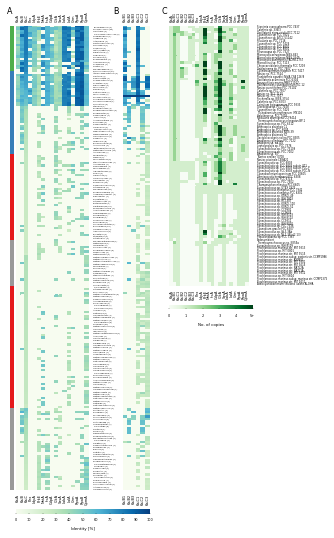

In [16]:
heatmap(df_Sy7942_sorted, df_Sy6803_sorted, df_count,
        '../heatmap.eps')

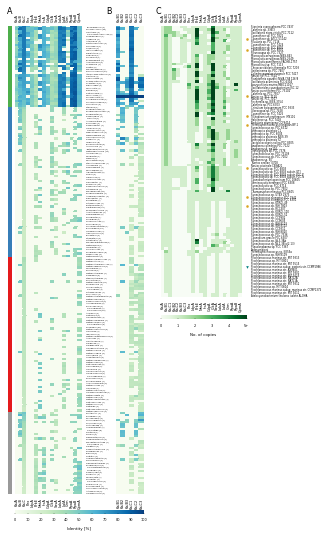

In [25]:
# Remove the plot frame lines.
def clean_axis(ax):
    for sp in ax.spines.values():
        sp.set_visible(False)

# Create the empty figure with 4.35 inch x 8.75 inch in size
f = plt.figure(figsize=(4.35,8.75))

hfont = {'fontname':'Bitstream Vera Sans'}
    
mlp.rcParams['lines.linewidth'] = 3
    
# Create a special grid von subplots
plots = gridspec.GridSpec(1, 2, width_ratios=[0.6,0.4],wspace=0.15)

#make nested gridspecs
p1 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec = plots[0],
                                      height_ratios=[0.993,0.007], hspace=0.07,
                                      width_ratios=[0.03,0.53,0.22,0.22], wspace=0.1)

p2 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec = plots[1],
                                      height_ratios=[0.6,0.01,0.39], hspace=0.12,
                                      width_ratios=[1,0.1], wspace=-0.09)

##########################################################################

syn_heat = f.add_subplot(p1[0,1])
    
# Remove the tick marks and place labels at top, bottom, and right  
syn_heat.tick_params(axis="both", which="both", bottom="off", top="off",
                left="off", right="off", labeltop="on", labelbottom="on", 
                labelleft="off", labelright="on")

clean_axis(syn_heat)

# Put the major ticks at the middle of each cell
syn_heat.set_xticks(np.arange(df_Sy7942_sorted.shape[1])+0.5, minor=False)
syn_heat.set_yticks(np.arange(df_Sy7942_sorted.shape[0])+0.5, minor=False)

# Add x-axis labels
syn_heat.set_xticklabels(['KaiA', 'KaiB', 'KaiC', 'Pex', 'LdpA', 'PrkE',
                          'NhtA', 'IrcA', 'CdpA', 'CikA', 'SasA', 'LabA',
                          'LalA', 'Crm', 'RpaA', 'RpaB', 'CpmA'],
                         fontsize=3.5, rotation=90, **hfont)

# Create a list with y-labels. Each y-label should contain 
# the genus name and the number of underlying organisms.
ylabels = []

for names, counts in zip(list(df_Sy7942_sorted.genus),list(df_Sy7942_sorted.kaiC_count)):
    ylabels.append(str(names)+' ('+str(int(counts))+')')

syn_heat.set_yticklabels(ylabels, fontsize=2, **hfont)

# Limit the range of the plot to only where the data is.  
# Avoid unnecessary whitespace.
syn_heat.set_ylim(plt.ylim(0, len(df_Sy7942_sorted.index))[::-1]) 

# Let's do the actual ploting
heat_syn = syn_heat.pcolor(df_Sy7942_sorted.iloc[:,4:-1], cmap='GnBu',vmin=0, vmax=100)

#########################

bc_heat = f.add_subplot(p1[0,3], sharey=syn_heat)
    
bc_heat.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="on", labelbottom="on", 
                    labelleft="off", labelright="off")

clean_axis(bc_heat)

bc_heat.set_xticks(np.arange(df_Sy6803_sorted.shape[1])+0.5, minor=False)

bc_heat.set_xticklabels(['KaiB1','KaiB2','KaiB3','KaiC1','KaiC2','KaiC3'],
                        fontsize=3.5, rotation=90, **hfont)    

bc_heat.pcolor(df_Sy6803_sorted.iloc[:,4:], cmap='GnBu',vmin=0, vmax=100) 

#########################

tax_bar = f.add_subplot(p1[0,0], sharey=syn_heat)

tax_bar.tick_params(axis="both", which="both", bottom="off", top="off",
                    left="off", right="off", labeltop="off", labelbottom="off", 
                    labelleft="off", labelright="off")
    
clean_axis(tax_bar)
    
# Create a colored bar that corresponds to the four groups.
tax_bar.pcolor(df_Sy7942_sorted.iloc[:,2:3], cmap='Set1',vmin=1, vmax=9)

##########################

bar_heat = f.add_subplot(p1[1,1:])
    
# Modify colorbar
cbar = f.colorbar(heat_syn, bar_heat, orientation='horizontal')

tick_locator = ticker.MaxNLocator(nbins=11)
cbar.locator = tick_locator

cbar.update_ticks() 

# Set labels and tick labels
cbar.ax.tick_params(length=1.5, width=0.3)
cbar.ax.set_xticklabels(np.arange(0,101,10), fontsize=3.5, **hfont)
cbar.set_label('Identity [%]', fontsize=4, **hfont)

cbar.outline.set_linewidth(0)

##########################
    
count_heat = f.add_subplot(p2[0,0])

count_heat.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft='off',
                labelright='on', labeltop="on")

clean_axis(count_heat)

PCC7942 = ['KaiA', 'KaiB1', 'KaiC1', 'KaiB2', 'KaiC2', 'KaiB3', 'KaiC3',
           'Pex', 'LdpA', 'PrkE', 'NhtA', 'IrcA', 'CdpA', 'CikA', 'SasA',
           'LabA', 'LalA', 'Crm', 'RpaA', 'RpaB', 'CpmA']

names = []

for n in df_count.name:
    names.append(n.split(' (')[0])

count_heat.set_xticks(np.arange(len(df_count.columns[1:]))+0.5, minor=False)
count_heat.set_xticklabels(PCC7942, fontsize=3.5, rotation=90, **hfont)

count_heat.set_yticks(np.arange(len(df_count.index))+0.5, minor=False)
count_heat.set_yticklabels(names, fontsize=2.5, rotation=0, **hfont)

count_heat.set_xlim(0, 22)
count_heat.set_ylim(0, len(df_count.index))

heatmap = count_heat.pcolor(df_count.iloc[:,1:], cmap='Greens', vmax=5, vmin=0)

count_heat.invert_yaxis()

########################

bar_count = f.add_subplot(p2[1,0])

cbar = f.colorbar(heatmap, bar_count, orientation='horizontal')

tick_locator = ticker.MaxNLocator(nbins=6)
cbar.locator = tick_locator

cbar.update_ticks()

cbar.ax.tick_params(length=1.5, width=0.3)
cbar.ax.set_xticklabels(['0','1','2','3','4','5+'], fontsize=3.5, **hfont)
cbar.set_label('No. of copies', fontsize=4, **hfont)

cbar.outline.set_linewidth(0)

#########################

clock = f.add_subplot(p2[0,1], sharey=count_heat)

clock.tick_params(axis="both", which="both", bottom="off", top="off",
                  left="off", right="off", labeltop="off", labelbottom="off", 
                  labelleft="off", labelright="off")

clean_axis(clock)

y1 = [4.5,8.5,24.5,31.5,34.5,49.5,59.5,62.5]
y2 = [83.5]

# Create a colored bar that corresponds to the four groups.
clock.scatter([0]*len(y1), y1, lw=0, s=8, color='goldenrod', marker='h')

clock.scatter([0]*len(y2), y2, lw=0, s=7, color='teal', marker='v')

clock.set_ylim(0,94)
clock.invert_yaxis()

###########################

syn_heat.text(-2,-5,'A',fontsize=8, **hfont)
bc_heat.text(-2,-5,'B',fontsize=8, **hfont)
bc_heat.text(8.5,-5,'C',fontsize=8, **hfont)
    
plt.savefig('../name.eps', format='eps', bbox_inches='tight', dpi=1000, transparent=True)

---
### Previous ###

+ [Data Collection and Processing](1_KaiABC_BLAST_Data_Collection_and_Perprocessing.ipynb)

### Next ###

+ [Length Distribution of KaiA, KaiB, KaiC](3_KaiABC_BLAST_Scatterplot.ipynb)
+ [Co-Occurence of Circadian Clock Proteins in Cyanobacteria](4_KaiABC_BLAST_FisherTest.ipynb)
+ [Additional Analyses](5_KaiABC_BLAST_Other.ipynb)

---